#### Prepare

In [ ]:
# Import packages
library("microbiome")
library("phyloseq")
library("ggplot2")
library("magrittr")
library("dplyr")
library("reshape2")
library("knitr")

In [2]:
# Import data
data(dietswap) 
# Only check the core taxa to speed up examples
pseq <- core(dietswap, detection = 10, prevalence = 50/100)

head(otu_table(pseq))
head(sample_data(pseq))
head(tax_table(pseq))

,Sample-1,Sample-2,Sample-3,Sample-4,Sample-5,Sample-6,Sample-7,Sample-8,Sample-9,Sample-10,⋯,Sample-213,Sample-214,Sample-215,Sample-216,Sample-217,Sample-218,Sample-219,Sample-220,Sample-221,Sample-222
Akkermansia,18,97,67,256,21,16,26,30,19,125,⋯,39,17,189,64,31,12,15,22,75,45
Allistipes et rel.,336,63,36,96,49,17,47,49,14,31,⋯,72,37,99,102,56,105,709,70,160,68
Anaerostipes caccae et rel.,244,137,27,36,23,29,58,49,23,29,⋯,31,24,15,14,92,13,26,60,27,73
Anaerotruncus colihominis et rel.,12,108,203,68,15,36,31,40,19,720,⋯,147,183,192,323,302,168,113,22,94,163
Anaerovorax odorimutans et rel.,6,73,30,60,12,9,45,14,14,32,⋯,12,12,10,12,21,30,11,11,18,43
Bacteroides fragilis et rel.,443,21,73,29,33,14,22,560,8,26,⋯,39,54,366,499,67,64,132,43,734,257


,subject,sex,nationality,group,sample,timepoint,timepoint.within.group,bmi_group
,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,<int>,<fct>
Sample-1,byn,male,AAM,DI,Sample-1,4,1,obese
Sample-2,nms,male,AFR,HE,Sample-2,2,1,lean
Sample-3,olt,male,AFR,HE,Sample-3,2,1,overweight
Sample-4,pku,female,AFR,HE,Sample-4,2,1,obese
Sample-5,qjy,female,AFR,HE,Sample-5,2,1,overweight
Sample-6,riv,female,AFR,HE,Sample-6,2,1,obese


,Phylum,Family,Genus
Akkermansia,Verrucomicrobia,Verrucomicrobia,Akkermansia
Allistipes et rel.,Bacteroidetes,Bacteroidetes,Allistipes et rel.
Anaerostipes caccae et rel.,Firmicutes,Clostridium cluster XIVa,Anaerostipes caccae et rel.
Anaerotruncus colihominis et rel.,Firmicutes,Clostridium cluster IV,Anaerotruncus colihominis et rel.
Anaerovorax odorimutans et rel.,Firmicutes,Clostridium cluster XI,Anaerovorax odorimutans et rel.
Bacteroides fragilis et rel.,Bacteroidetes,Bacteroidetes,Bacteroides fragilis et rel.


#### EdgeR analysis

In [12]:
# Define function
# from http://joey711.github.io/phyloseq-extensions/edgeR.html
phyloseq_to_edgeR = function(physeq, group, method="RLE", ...){
  require("edgeR")
  require("phyloseq")
  # Enforce orientation.
  if( !taxa_are_rows(physeq) ){ physeq <- t(physeq) }
  x = as(otu_table(physeq), "matrix")
  # Add one to protect against overflow, log(0) issues.
  x = x + 1
  # Check `group` argument
  if( identical(all.equal(length(group), 1), TRUE) & nsamples(physeq) > 1 ){
    # Assume that group was a sample variable name (must be categorical)
    group = get_variable(physeq, group)
  }
  # Define gene annotations (`genes`) as tax_table
  taxonomy = tax_table(physeq, errorIfNULL=FALSE)
  if( !is.null(taxonomy) ){
    taxonomy = data.frame(as(taxonomy, "matrix"))
  } 
  # Now turn into a DGEList
  y = DGEList(counts=x, group=group, genes=taxonomy, remove.zeros = TRUE, ...)
  # Calculate the normalization factors
  z = calcNormFactors(y, method=method)
  # Check for division by zero inside `calcNormFactors`
  if( !all(is.finite(z$samples$norm.factors)) ){
    stop("Something wrong with edgeR::calcNormFactors on this data,
         non-finite $norm.factors, consider changing `method` argument")
  }
  # Estimate dispersions
  return(estimateTagwiseDisp(estimateCommonDisp(z)))
}

In [15]:
# edgeR analysis
dge <- phyloseq_to_edgeR(pseq, group = 'nationality')
et <- exactTest(dge)
# Extract values from test results
tt <- topTags(et, n=nrow(dge$table), adjust.method="BH", sort.by="PValue")
res <- tt@.Data[[1]]
alpha <- 0.001
sigtab <- res[(res$FDR < alpha), ]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(pseq)[rownames(sigtab), ], "matrix"))
dim(sigtab)

head(sigtab)

[1] 32 10

,Phylum,Family,Genus,logFC,logCPM,PValue,FDR,Phylum,Family,Genus
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
Bacteroides ovatus et rel.,Bacteroidetes,Bacteroidetes,Bacteroides ovatus et rel.,-2.466332,13.12708,8.490332e-53,4.754586e-51,Bacteroidetes,Bacteroidetes,Bacteroides ovatus et rel.
Allistipes et rel.,Bacteroidetes,Bacteroidetes,Allistipes et rel.,-2.549660,14.27481,1.653360e-51,4.629408e-50,Bacteroidetes,Bacteroidetes,Allistipes et rel.
Clostridium difficile et rel.,Firmicutes,Clostridium cluster XI,Clostridium difficile et rel.,2.062225,11.38414,1.379305e-48,2.574702e-47,Firmicutes,Clostridium cluster XI,Clostridium difficile et rel.
Bacteroides plebeius et rel.,Bacteroidetes,Bacteroidetes,Bacteroides plebeius et rel.,-1.857022,11.88402,4.846236e-41,6.784730e-40,Bacteroidetes,Bacteroidetes,Bacteroides plebeius et rel.
Bacteroides vulgatus et rel.,Bacteroidetes,Bacteroidetes,Bacteroides vulgatus et rel.,-2.865807,16.61937,4.213470e-40,4.719086e-39,Bacteroidetes,Bacteroidetes,Bacteroides vulgatus et rel.
Bacteroides stercoris et rel.,Bacteroidetes,Bacteroidetes,Bacteroides stercoris et rel.,-2.175536,11.34521,1.371941e-35,1.280478e-34,Bacteroidetes,Bacteroidetes,Bacteroides stercoris et rel.


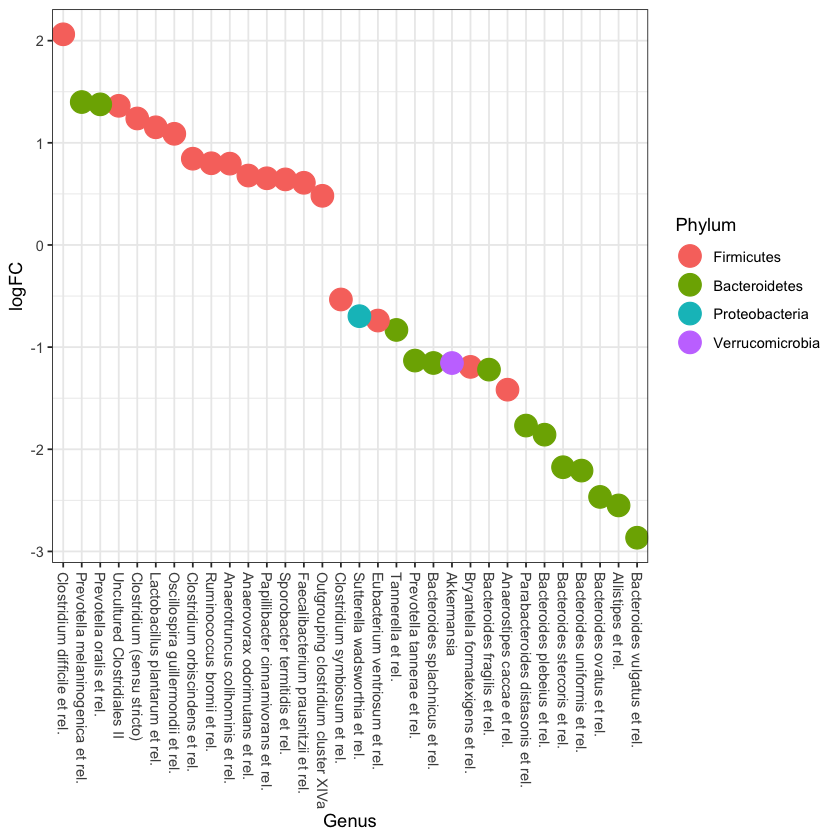

In [16]:
# Plot
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
    scale_fill_brewer(palette = palname, ...)
}
sigtabgen = subset(sigtab, !is.na(Genus))
# Phylum order
x = tapply(sigtabgen$logFC, sigtabgen$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Phylum = factor(as.character(sigtabgen$Phylum), levels = names(x))
# Genus order
x = tapply(sigtabgen$logFC, sigtabgen$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Genus = factor(as.character(sigtabgen$Genus), levels = names(x))
ggplot(sigtabgen, aes(x = Genus, y = logFC, color = Phylum)) + geom_point(size = 6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust = 0.5))